In [31]:
import tensorflow as tf
# import numpy as np### math computations
# import matplotlib.pyplot as plt### plotting bar chart
# import sklearn### machine learning library
# import cv2## image processing
# from sklearn.metrics import confusion_matrix, roc_curve### metrics
# import seaborn as sns### visualizations
import datetime # For Datetime Functions
import pathlib # handling files and paths on your operating system
import io # dealing with various types of I/O
import os 
import re # for Regular Expressions
import string
import time
import pandas as pd
from numpy import random
from datasets import Dataset, DatasetDict,NamedSplit
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=8

In [3]:
# Load the amazon review dataset
df = pd.read_csv('../data/IMDB Dataset.csv')

In [4]:
df = df.sample(5000)
new_values = {"negative":0,"positive":1 }
df['sentiment'] = df['sentiment'].replace(new_values)

C:\Users\papal\AppData\Local\Temp\ipykernel_15152\2205507983.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace(new_values)


In [5]:
df

,review,sentiment
44033,Many experienced and excellent actors mixed to...,1
42136,L'Humanité is a murder mystery. These movies t...,0
23174,Having seen the full length film Kieslowski ma...,1
44156,This movie is simply awesome.It was a very sen...,1
47981,"NO SPOILERS.<br /><br />I love horror movies, ...",0
...,...,...
17401,You just got to love opening sequences like th...,0
45766,"In WWII, America has developed a brand-new HUG...",1
40253,"When I think about TV movies, I always think o...",0
11992,This movie was a rather odd viewing experience...,0


In [6]:
dataset = Dataset.from_pandas(df, split='train',preserve_index=False)
dataset = dataset.train_test_split(test_size=0.3)

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 1500
    })
})

In [8]:
pd.DataFrame({'text':dataset['train'][:5]['review'],'label':dataset['train'][:5]['sentiment']})

,text,label
0,"You all know the story of ""Hamlet"". I do. <br ...",0
1,I found this movie to be very good in all area...,1
2,Streisand fans only familiar with her work fro...,1
3,I have never read Sarah Water's book. Although...,1
4,"Just saw this movie, and what a waste of time....",0


In [9]:
model_id="bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_id)

In [10]:
test_input_1='The Weather of Today is Gréat! zwp'
test_input_2='How are you doing?'
inputs=[test_input_1,test_input_2]

tokenizer.tokenize(inputs)

['the',
 'weather',
 'of',
 'today',
 'is',
 'great',
 '!',
 'z',
 '##w',
 '##p',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [11]:
output=tokenizer(inputs,padding=True,truncation=True,max_length=128)
print(output)

{'input_ids': [[101, 1996, 4633, 1997, 2651, 2003, 2307, 999, 1062, 2860, 2361, 102], [101, 2129, 2024, 2017, 2725, 1029, 102, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


In [12]:
tokenizer.decode(output['input_ids'][1])

'[CLS] how are you doing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [13]:
def preprocess_function(examples):
  return tokenizer(examples["review"],padding=True,truncation=True,)

In [14]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset

Map: 100%|██████████| 1500/1500 [00:00<00:00, 2269.11 examples/s]


DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3500
    })
    test: Dataset({
        features: ['review', 'sentiment', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1500
    })
})

In [15]:
pd.DataFrame({
    'text':tokenized_dataset['train'][:5]['review'],
    'label':tokenized_dataset['train'][:5]['sentiment'],
    'input_ids':tokenized_dataset['train'][:5]['input_ids'],
    'token_type_ids':tokenized_dataset['train'][:5]['token_type_ids'],
    'attention_mask':tokenized_dataset['train'][:5]['attention_mask']
    })

,text,label,input_ids,token_type_ids,attention_mask
0,"You all know the story of ""Hamlet"". I do. <br ...",0,"[101, 2017, 2035, 2113, 1996, 2466, 1997, 1000...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,I found this movie to be very good in all area...,1,"[101, 1045, 2179, 2023, 3185, 2000, 2022, 2200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Streisand fans only familiar with her work fro...,1,"[101, 2358, 2890, 29196, 2094, 4599, 2069, 522...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,I have never read Sarah Water's book. Although...,1,"[101, 1045, 2031, 2196, 3191, 4532, 2300, 1005...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"Just saw this movie, and what a waste of time....",0,"[101, 2074, 2387, 2023, 3185, 1010, 1998, 2054...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [16]:
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'sentiment'],
    shuffle=True,
    batch_size=BATCH_SIZE,
)

In [17]:

tf_val_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'sentiment'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    #collate_fn=data_collator
)

In [18]:
def swap_positions(dataset):
  print(dataset)
  return {'input_ids':dataset['input_ids'],
          'token_type_ids':dataset['token_type_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['sentiment']

In [19]:
tf_train_dataset

<_PrefetchDataset element_spec={'sentiment': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}>

In [20]:
tf_train_dataset=tf_train_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)
tf_val_dataset=tf_val_dataset.map(swap_positions).prefetch(tf.data.AUTOTUNE)

{'sentiment': <tf.Tensor 'args_2:0' shape=(None,) dtype=int64>, 'input_ids': <tf.Tensor 'args_1:0' shape=(None, 512) dtype=int64>, 'token_type_ids': <tf.Tensor 'args_3:0' shape=(None, 512) dtype=int64>, 'attention_mask': <tf.Tensor 'args_0:0' shape=(None, 512) dtype=int64>}
{'sentiment': <tf.Tensor 'args_2:0' shape=(None,) dtype=int64>, 'input_ids': <tf.Tensor 'args_1:0' shape=(None, 512) dtype=int64>, 'token_type_ids': <tf.Tensor 'args_3:0' shape=(None, 512) dtype=int64>, 'attention_mask': <tf.Tensor 'args_0:0' shape=(None, 512) dtype=int64>}


In [21]:
tf_train_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [22]:
for i in tf_train_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[  101,  2009,  1005, ...,     0,     0,     0],
       [  101,  1045,  3866, ...,     0,     0,     0],
       [  101, 26380,  6373, ...,     0,     0,     0],
       ...,
       [  101,  2023,  2003, ...,     0,     0,     0],
       [  101,  1999,  1996, ...,     0,     0,     0],
       [  101,  2023,  3185, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(8, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}, <tf.Tensor: shape=(8,), dtype=int64, nu

In [23]:
model=TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)
model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  769       
                                                                 
Total params: 109483009 (417.64 MB)
Trainable params: 109483009 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
num_epochs = 3
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [25]:
# Optimizer
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy'],)
    #run_eagerly=True)

In [27]:
history=model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=3)

Epoch 1/3


438/438 [==============================] - 6422s 15s/step - loss: 0.8735 - accuracy: 0.7517 - val_loss: 0.6393 - val_accuracy: 0.6773
Epoch 2/3
438/438 [==============================] - 6396s 15s/step - loss: 0.3434 - accuracy: 0.8846 - val_loss: 0.5134 - val_accuracy: 0.8980
Epoch 3/3
438/438 [==============================] - 6393s 15s/step - loss: 0.5244 - accuracy: 0.8357 - val_loss: 0.5191 - val_accuracy: 0.7853


In [29]:

model.save_pretrained("./Bert_5000", from_pt=True) 

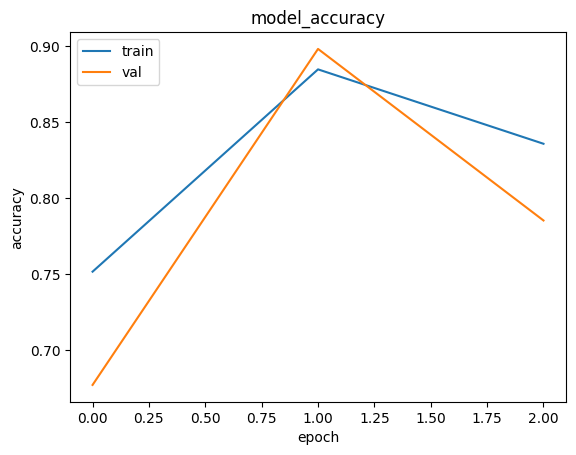

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

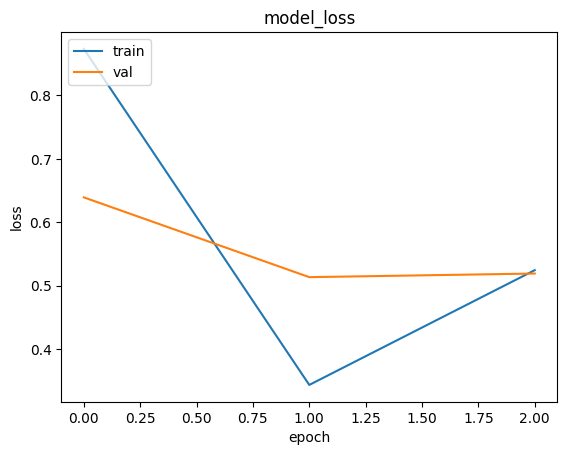

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
inputs = tokenizer(["The movie was crap",
                    "very good start, but movie started becoming uninteresting at some point though initially i thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so over "], padding=True,return_tensors="tf")

logits = model(**inputs).logits
print(logits)

# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)

# Print the probabilities
print(probabilities)

tf.Tensor(
[[-0.17057462]
 [ 0.16399564]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)
